# BOT

In [3]:
import keras
from keras.datasets import cifar10

num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

/Users/aizhan/.virtualenvs/prep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from keras import applications
vgg_model = applications.VGG19(include_top=False, weights='imagenet')
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [5]:
bottleneck_features_train = vgg_model.predict(x_train, verbose=1)
bottleneck_features_test = vgg_model.predict(x_test, verbose=1)

10000/10000 [==============================] - 111s 11ms/step


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

clf_model = Sequential()
clf_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
clf_model.add(Dense(512, activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(256, activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(num_classes, activation='softmax'))
clf_model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adadelta(),
metrics=['accuracy'])

In [7]:
clf_model.fit(bottleneck_features_train, y_train, 
              batch_size=100, epochs=50, verbose=1)

Epoch 1/50
50000/50000 [==============================] - 6s 113us/step - loss: 4.7220 - acc: 0.2880
Epoch 2/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.8124 - acc: 0.3797
Epoch 3/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.6397 - acc: 0.4371
Epoch 4/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.5470 - acc: 0.4729
Epoch 5/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.4856 - acc: 0.4954
Epoch 6/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.4363 - acc: 0.5136
Epoch 7/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.3998 - acc: 0.5286
Epoch 8/50
50000/50000 [==============================] - 6s 110us/step - loss: 1.3758 - acc: 0.5386
Epoch 9/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.3441 - acc: 0.5502
Epoch 10/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.3273 - a

In [21]:
import numpy as np
from matplotlib import pyplot as plt

In [22]:
def predict_label(img_idx,show_proba=True):
    plt.imshow(x_test[img_idx],aspect='auto')
    plt.title("Image to be Labeled")
    plt.show()
    print("Actual Class:{}".format(np.nonzero(y_test[img_idx])[0][0]))

    test_image =np.expand_dims(x_test[img_idx], axis=0)
    bf = vgg_model.predict(test_image,verbose=0)
    pred_label = clf_model.predict_classes(bf,batch_size=1,verbose=0)

    print("Predicted Class:{}".format(pred_label[0]))
    if show_proba:
        print("Predicted Probabilities")
        print(clf_model.predict_proba(bf))

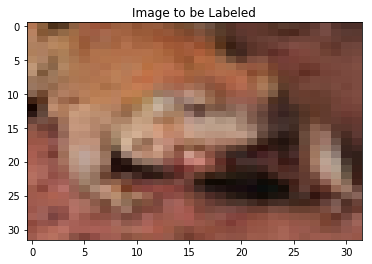

Actual Class:6
Predicted Class:6
Predicted Probabilities
[[0.00425594 0.00410257 0.07325516 0.18542951 0.1837368  0.13254578
  0.37780175 0.02845585 0.00582204 0.00459461]]


In [25]:
img_idx = 5

predict_label(img_idx)

In [26]:
token = ''

import telebot

bot = telebot.TeleBot(token)
    

In [27]:
import PIL
from PIL import Image
import requests
from io import BytesIO


labels = [
    'airplane', 
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

def out_predict_label(url, message, show_proba=True): 
    bot.send_message(message.chat.id, "downloading..")
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    
    bot.send_message(message.chat.id, "resizing..")
    img = img.resize((32, 32), PIL.Image.ANTIALIAS)
    img.save('resized_image.png')
    
    bot.send_message(message.chat.id, "still wait")
    

    plt.imshow(img,aspect='auto')
    plt.title("Image to be Labeled")
    plt.show()
    
    bot.send_message(message.chat.id, "started prediction..")
    test_image =np.expand_dims(img, axis=0)
    bf = vgg_model.predict(test_image,verbose=0)
    pred_label = clf_model.predict_classes(bf,batch_size=1,verbose=0)
    
    print(pred_label[0])
    index = pred_label[0]
    print("Predicted Class:{}".format(pred_label[0]))
 
    if show_proba:
        print("Predicted Probabilities")
        print(clf_model.predict_proba(bf))
        bot.send_message(message.chat.id, "I think it is a " + labels[index])
  

In [28]:
@bot.message_handler(content_types=["photo"])
def predict_image(message):
    bot.send_message(message.chat.id, "wait")
    img = message.photo
    print (message.photo)
    fileID = message.photo[-1].file_id
    print ('fileID =', fileID)
    file = bot.get_file(fileID)
    print ('file.file_path =', file.file_path)
    path = 'https://api.telegram.org/file/bot' + token +'/'+ file.file_path
    out_predict_label(path, message)

@bot.message_handler(content_types=['document', 'audio', 'text'])
def response_to_not_photo(message):
    bot.send_message(message.chat.id, "Hey " + message.chat.username + " please send only photo")


[<telebot.types.PhotoSize object at 0x12c5d57f0>, <telebot.types.PhotoSize object at 0x12c5d57b8>]
fileID = AgADAgADcKkxGyg7yUnIw42B5Fft5lW0qw4ABKksMbMW4R5DCBMAAgI
file.file_path = photos/file_6.jpg


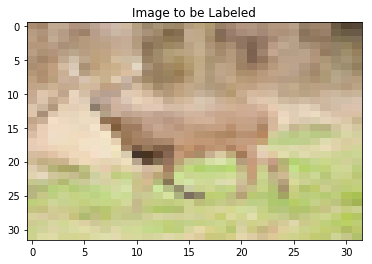

4
Predicted Class:4
deer
Predicted Probabilities
[[3.4027395e-05 1.1420668e-08 1.6312040e-02 3.7553310e-03 9.5186597e-01
  8.5912514e-03 2.9580560e-04 1.9143304e-02 1.2983752e-06 9.7209681e-07]]


In [29]:
if __name__ == '__main__':
    bot.polling(none_stop=True)